In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv1D, MaxPool1D

In [2]:
with open("Intent.json") as chatbot_dataset:
  dataset = json.load(chatbot_dataset)

In [3]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [4]:
[tags, inputs, responses] = processing_json_dataset(dataset)

In [5]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [6]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [7]:
dataset = dataset.sample(frac=1)

In [8]:
dataset.head()

,inputs,tags
45,What's your real name?,RealNameQuery
163,Why will you not open the pod bay door,PodBayDoorResponse
86,I want to connect with my boss,ProblemsWithBoss
10,It is Adam,GreetingResponse
20,Hope you are doing well?,CourtesyGreeting


In [9]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [10]:
dataset.head()

,inputs,tags
45,"[w, h, a, t, s, , y, o, u, r, , r, e, a, l, ...",RealNameQuery
163,"[w, h, y, , w, i, l, l, , y, o, u, , n, o, ...",PodBayDoorResponse
86,"[i, , w, a, n, t, , t, o, , c, o, n, n, e, ...",ProblemsWithBoss
10,"[i, t, , i, s, , a, d, a, m]",GreetingResponse
20,"[h, o, p, e, , y, o, u, , a, r, e, , d, o, ...",CourtesyGreeting


In [11]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [12]:
dataset.head()

,inputs,tags
45,whats your real name,RealNameQuery
163,why will you not open the pod bay door,PodBayDoorResponse
86,i want to connect with my boss,ProblemsWithBoss
10,it is adam,GreetingResponse
20,hope you are doing well,CourtesyGreeting


In [13]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [14]:
len(features[0])

10

In [15]:
input_shape = features.shape[1]
print(input_shape)

10


In [16]:
features.shape

(174, 10)

In [17]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  168
output length:  28


In [18]:
tokenizer.word_index

{'you': 1,
 'i': 2,
 'me': 3,
 'is': 4,
 'am': 5,
 'my': 6,
 'are': 7,
 'to': 8,
 'what': 9,
 'can': 10,
 'do': 11,
 'the': 12,
 'thanks': 13,
 'name': 14,
 'a': 15,
 'please': 16,
 'your': 17,
 'tell': 18,
 'pod': 19,
 'bay': 20,
 'door': 21,
 'want': 22,
 'open': 23,
 'adam': 24,
 'bella': 25,
 'how': 26,
 'real': 27,
 'not': 28,
 'time': 29,
 'prove': 30,
 'why': 31,
 'it': 32,
 'talking': 33,
 'gossip': 34,
 'boss': 35,
 'call': 36,
 'good': 37,
 'this': 38,
 'see': 39,
 'have': 40,
 'know': 41,
 'hello': 42,
 'very': 43,
 'wasnt': 44,
 'joke': 45,
 'who': 46,
 'user': 47,
 'bye': 48,
 'great': 49,
 'thank': 50,
 'stress': 51,
 'goodbye': 52,
 'will': 53,
 'with': 54,
 'doing': 55,
 'well': 56,
 'girl': 57,
 'stressed': 58,
 'ok': 59,
 'be': 60,
 'quiet': 61,
 'there': 62,
 'clever': 63,
 'depressed': 64,
 'hi': 65,
 'self': 66,
 'conscious': 67,
 'up': 68,
 'some': 69,
 'for': 70,
 'any': 71,
 'whats': 72,
 'hope': 73,
 'intelligent': 74,
 'fuck': 75,
 'off': 76,
 'selfaware': 77,

In [19]:
model = Sequential()
model.add(Input(shape=(features.shape[1])))
model.add(Embedding(vocabulary + 1,100))
model.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
model.add(Dropout(0.3))
model.add(LSTM(32, dropout=0.3,return_sequences=True))
model.add(LSTM(16, dropout=0.3,return_sequences=False))
model.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
model.add(Dropout(0.6))
model.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [20]:
model.layers

In [21]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [22]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [23]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [24]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           16900     
                                                                 
 conv1d (Conv1D)             (None, 6, 32)             16032     
                                                                 
 dropout (Dropout)           (None, 6, 32)             0         
                                                                 
 lstm (LSTM)                 (None, 6, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [26]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [27]:
history_training = model.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 [==============================] - 4s 19ms/step - loss: 3.3390 - accuracy: 0.0345
Epoch 2/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.3403 - accuracy: 0.0172
Epoch 3/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.3331 - accuracy: 0.0345
Epoch 4/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.3274 - accuracy: 0.0517
Epoch 5/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.3205 - accuracy: 0.0402
Epoch 6/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.3239 - accuracy: 0.0287
Epoch 7/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.3256 - accuracy: 0.0287
Epoch 8/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.3170 - accuracy: 0.0402
Epoch 9/2000
3/3 [==============================] - 0s 13ms/step - loss: 3.3000 - accuracy: 0.0747
Epoch 10/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.2996 - accuracy: 0.0690
Epoch 11/

In [28]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

C:\Users\likhi\AppData\Local\Temp\ipykernel_2708\3172170717.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


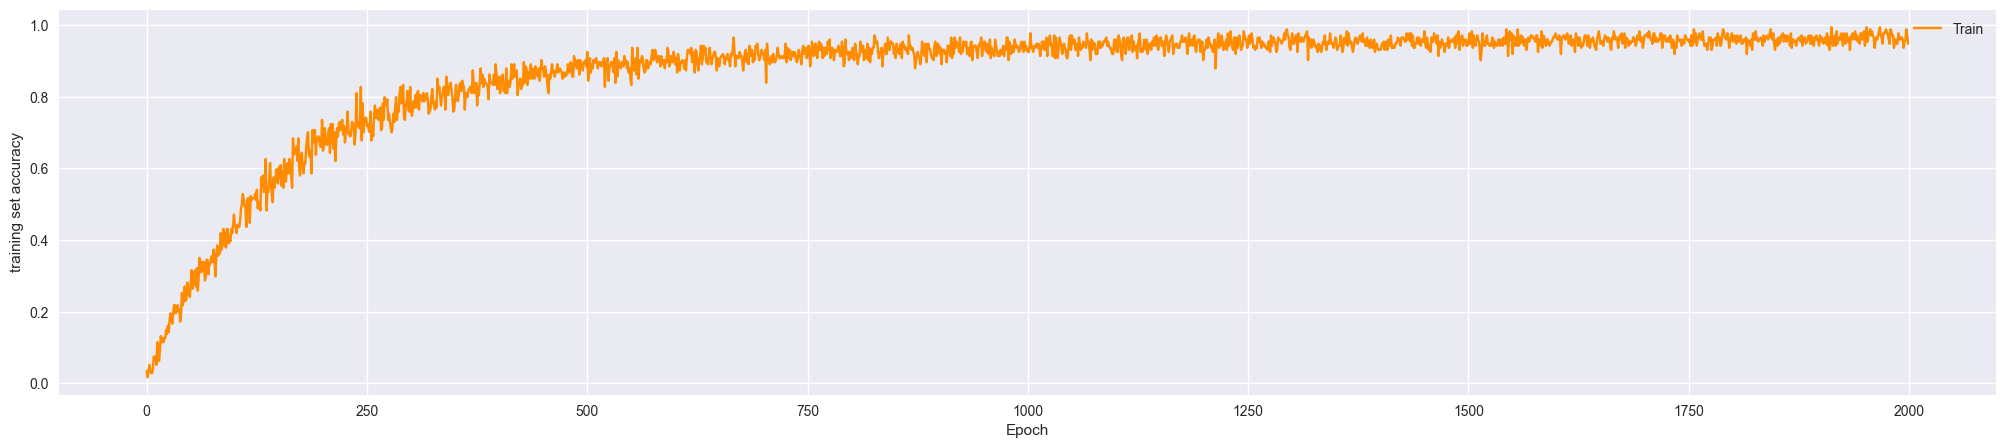

In [29]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

C:\Users\likhi\AppData\Local\Temp\ipykernel_2708\3172170717.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


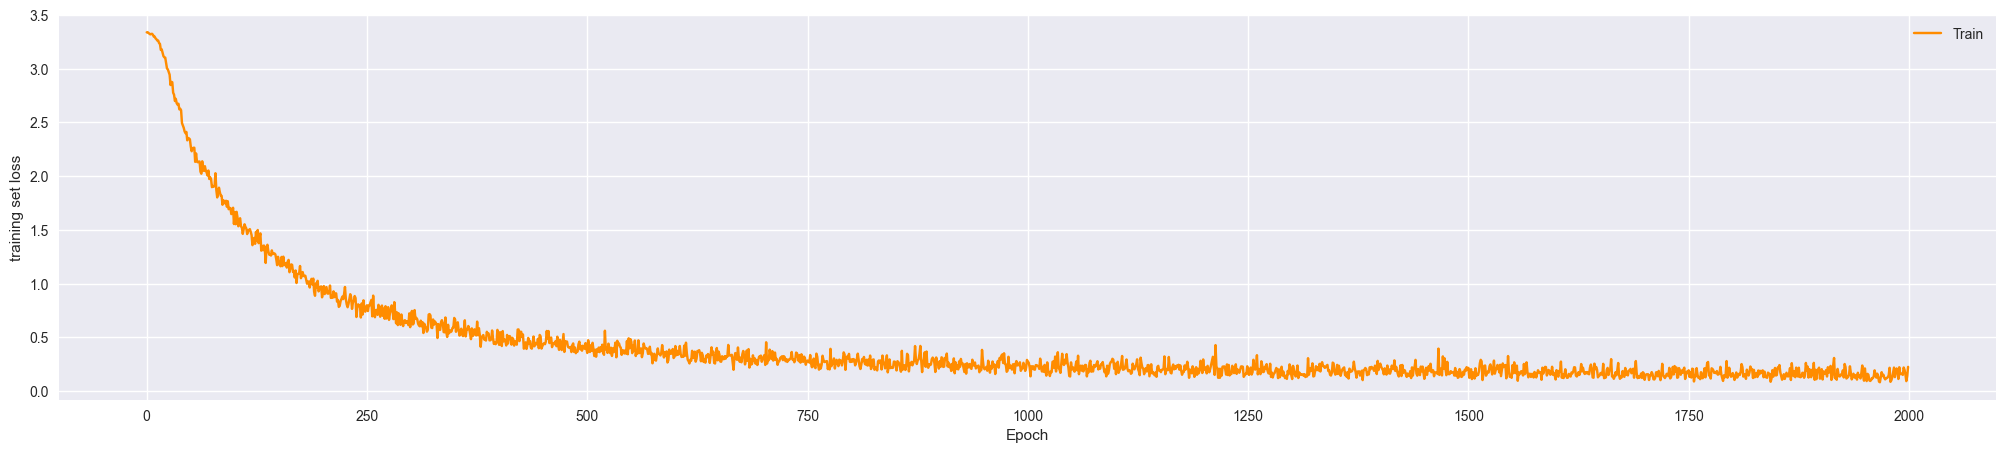

In [30]:
draw_plot(history_training.history['loss'],'training set loss' )

In [31]:
model.evaluate(features, labels, batch_size = 64)

3/3 [==============================] - 1s 3ms/step - loss: 0.0468 - accuracy: 0.9943


[0.04684899374842644, 0.9942528605461121]

In [32]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = model.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [33]:
list_que = ["hello", "i am kaled","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)  

you: hello
1/1 [==============================] - 1s 671ms/step
Hello human, please tell me your BotWork user
you: i am kaled
1/1 [==============================] - 0s 18ms/step
OK! hi <HUMAN>, what can I do for you?
you: what is my name?
1/1 [==============================] - 0s 18ms/step
You are <HUMAN>! How can I help?
you: what is your name?
1/1 [==============================] - 0s 16ms/step
You may call me BotWork
you: tell me please, what is your name?
1/1 [==============================] - 0s 21ms/step
You may call me BotWork


In [34]:
model.save("chatbot_model.h5")

In [38]:
x=str(input())
response=generate_answer(x)
print(response)

1/1 [==============================] - 0s 17ms/step
Bye! Come back again soon.
